# Noise in abstractive summarization

Предполагаемый пайплайн:
1. AESLC BERT (берт, unsupervised (на MLM task) дообученный на AESLC) --> эмбеддинги входных текстов (видимо, как усреденные пословные)
2. На полученных примерах считаем центроиды и ков. матрицу
3. Считаем расстояние Махаланобиса от центроидов 
4. Откидываем далекие примеры по трешхолду
5. Пересчитываем центроиды и ков. матрицу
6. Повторяем 2-6, пока центроиды меняются
7. Переучивыем модель для суммаризации на данных без выбросов и замеряем качество

In [1]:
%env WANDB_PROJECT=noise-in-abs-sum

import os
import warnings
from datasets import load_dataset, load_from_disk, DatasetDict, Dataset

from copy import deepcopy
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import random

warnings.filterwarnings('ignore')
os.environ["HF_DATASETS_OFFLINE"] = "1"
os.environ["WANDB_PROJECT"] = "noise-in-abs-sum"
CACHE_DIR_PATH = "/home/vakarlov/hf-cache-dir"

env: WANDB_PROJECT=noise-in-abs-sum


In [2]:
SEED = 42

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_random_seed(SEED)

## Loading dataset

In [3]:
# ! pip install -r requirements.txt --quiet

In [4]:
# ! pip install datasets --quiet
# ! pip install transformers --quiet
# ! pip install evaluate --quiet

In [5]:
dataset_name = "noisy_xsum_sample"

if dataset_name == "aeslc":
    raw_data = load_dataset(dataset_name, cache_dir=CACHE_DIR_PATH)
    raw_data = raw_data.rename_column("email_body", "text").rename_column("subject_line", "summary")
elif dataset_name == "xsum":
    raw_data = load_dataset(dataset_name, cache_dir=CACHE_DIR_PATH)
    raw_data = raw_data.rename_column("document", "text")
elif dataset_name in ["xsum_sample", "noisy_xsum_sample", "noisy_aeslc"]:
    raw_data = load_from_disk(f"{CACHE_DIR_PATH}/{dataset_name}.hf")
else:
    raise NotImplementedError('Unknown dataset')

In [6]:
raw_data

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'id', '__index_level_0__'],
        num_rows: 22000
    })
    validation: Dataset({
        features: ['text', 'summary', 'id', '__index_level_0__'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['text', 'summary', 'id', '__index_level_0__'],
        num_rows: 1500
    })
})

In [7]:
df = pd.DataFrame()
df['text'] = raw_data['train']['text']
df['summary'] = raw_data['train']['summary']

df

,text,summary
0,They recorded their best result in Wales in 30...,The general election dominated politics in Wal...
1,"More than 1,500 children were held over allege...",Children as young as 10 were among hundreds of...
2,"It includes:\nCertainly, Sinn Féin leader Gerr...",A bewildering list of developments has contrib...
3,"Then a young man in his mid-20s, the future mu...","In March 1959, as Chinese troops crushed an at..."
4,"Almost 2,000 homes and more than 1,000 busines...",A £3m fund to invest in flood prevention and r...
...,...,...
21995,"Ken, I just wanted you to know that I have bee...",General
21996,We'll just be doing some house shopping.\nI th...,This Weekend
21997,1.\nJust wanted to let you know that not every...,California
21998,T has called to say all issues with regards t...,Tractebel


In [8]:
lens = list(map(len, raw_data['train']['text']))

In [16]:
np.mean(lens[:14000])

2212.8319285714288

In [17]:
np.quantile(lens[:14000], 0.95)

5484.0

In [18]:
np.mean(lens[14400:])

1834.4569736842104

In [94]:
# np.quantile(lens[14400:], 0.95)

# MD Filtration

## Embeddings: Unsupervised fine-tuned bert

In [9]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

if dataset_name in ['xsum_sample', 'noisy_xsum_sample', 'xsum']:
    tokenizer = AutoTokenizer.from_pretrained("Aktsvigun/bert-base-xsum")
    model = AutoModelForMaskedLM.from_pretrained("Aktsvigun/bert-base-xsum", 
                                                 output_hidden_states=True)
elif dataset_name in ['aeslc', 'noisy_aeslc']:
    tokenizer = AutoTokenizer.from_pretrained("Aktsvigun/bert-base-aeslc")
    model = AutoModelForMaskedLM.from_pretrained("Aktsvigun/bert-base-aeslc", 
                                                 output_hidden_states=True)
else:
    raise NotImplementedError('Unknown dataset')

In [20]:
# # SMALL EXAMPLE 

# text_embeddings = torch.Tensor([]).reshape(0, 768)

# model.eval()
# sentences = [ 
#               "Hello I'm a single sentence",
#               "And another sentence",
#               "And the very very last one",
#               "Hello I'm a single sentence",
#               "And another sentence",
#               "And the very very last one",
#               "Hello I'm a single sentence",
#               "And another sentence",
#               "And the very very last one",
#             ]

# batch_size = 4  
# for idx in range(0, len(sentences), batch_size):
#     batch_att_masks = torch.Tensor([]).reshape(0, 50)
#     batch = sentences[idx : min(len(sentences), idx+batch_size)]
    
#     encoded = tokenizer(batch, max_length=50, padding='max_length', truncation=True)
#     batch_att_masks = torch.cat((batch_att_masks, torch.Tensor(encoded['attention_mask'])))
#     encoded = {key:torch.LongTensor(value) for key, value in encoded.items()}

#     with torch.no_grad():
#         outputs = model(**encoded)
#         last_hidden_state = outputs.hidden_states[-1]
#         # print(last_hidden_state.shape)
#         # text_embeddings.append(torch.squeeze(torch.mean(last_hidden_state, axis=1), dim=0))
#         # text_embeddings.append(torch.mean(last_hidden_state, axis=1))

#         # без учета паддинга -- torch.mean(last_hidden_state, dim=1)
#         # если хотим учитывать паддинг в знаменателе среднего -- просто torch.mean(tmp, dim=1)
#         new_text_embs = torch.sum(batch_att_masks.unsqueeze(-1) * last_hidden_state, dim=1) / torch.sum(batch_att_masks.unsqueeze(-1), dim=1)
#         text_embeddings = torch.cat((text_embeddings, new_text_embs))
        
  
#     # print(outputs.logits.size())
#     # print(len(outputs.hidden_states))
#     # print(outputs.hidden_states[-1].size())

#     # break

In [10]:
torch.cuda.empty_cache()

if torch.cuda.is_available():       
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

model.to(device)
print('device =', device)

device = cuda


In [22]:
# if "encoder" in hidden_state:
#     mask = batch["attention_mask"][:, :, None]
#     seq_lens = batch["attention_mask"].sum(-1)[:, None]
#     if ignore_padding:
#         batch_embeddings = (output.encoder_hidden_states[-1] * mask).sum(
#             1
#         ) / seq_lens
#     else:
#         batch_embeddings = (output.encoder_hidden_states[-1] * mask).mean(1)

In [112]:
# df = pd.concat([df.iloc[:2], df.iloc[-2:]])

In [113]:
# df

,text,summary,MD,labels
0,"Greg/Phillip, Attached is the Grande Communic...",Service Agreement,14.097210,0.0
1,Phillip & Keith Attached is the first draw re...,Bishops Corner,23.570900,0.0
15877,"In 2014/15, 9.76 days per person were lost to ...",Sick days at Devon and Somerset Fire and Rescu...,41.291435,1.0
15878,Media playback is not supported on this device...,Lewis Hamilton says he wants to race in Formul...,61.305256,1.0


In [11]:
from tqdm import tqdm

ebm_size = 768
tokens_max_length = 512
# tokens_max_length = 128
ignore_padding = False

hs_text_embeddings = torch.Tensor([]).reshape(0, ebm_size).to(device)
model.eval()

# batch_size = 2  
batch_size = 128
for idx in tqdm(range(0, len(df), batch_size)):
    batch = df[idx : min(len(df), idx + batch_size)]['text'].tolist()
    encoded = tokenizer(batch, max_length=tokens_max_length, padding='max_length',
                        truncation=True, return_tensors='pt')
    encoded = {key:value.to(device) for key, value in encoded.items()}  # положили на девайс
    batch_att_masks = encoded['attention_mask'].to(device)
    # print(batch_att_masks[0].sum())
    with torch.no_grad():
        outputs = model(**encoded)
        last_hidden_state = outputs.hidden_states[-1]
        # print('l_hs shape:', last_hidden_state.shape)
        # print('batch_att_masks shape:', batch_att_masks.unsqueeze(-1).shape)

        # без учета паддинга -- torch.mean(last_hidden_state, dim=1)
        # если хотим учитывать паддинг в знаменателе среднего -- просто torch.mean(tmp, dim=1)
        if ignore_padding:
            new_text_embs = torch.sum(batch_att_masks.unsqueeze(-1) * last_hidden_state, dim=1) /\
                            torch.sum(batch_att_masks.unsqueeze(-1), dim=1)
        else:
            new_text_embs = torch.mean(batch_att_masks.unsqueeze(-1) * last_hidden_state, dim=1)
        
        # print(torch.sum(batch_att_masks.unsqueeze(-1), dim=1))
        # print((batch_att_masks.unsqueeze(-1) * last_hidden_state))
        # print(new_text_embs.shape)
        hs_text_embeddings = torch.cat((hs_text_embeddings, new_text_embs))
        # print(hs_text_embeddings)


100%|██████████| 172/172 [03:05<00:00,  1.08s/it]


In [12]:
hs_text_embeddings = hs_text_embeddings.detach().cpu()

In [13]:
print(hs_text_embeddings.size())

torch.Size([22000, 768])


In [16]:
print(f"text_embeddings/{dataset_name}_hs_text_embeddings_ign_pad_false.pt")

text_embeddings/noisy_xsum_sample_hs_text_embeddings_ign_pad_false.pt


In [18]:
torch.save(hs_text_embeddings, f"text_embeddings/{dataset_name}_hs_text_embeddings_ign_pad_false.pt")

## Embeddings: SBERT

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2')

In [ ]:
sbert_text_embeddings = model.encode(df['text'], batch_size=256, convert_to_tensor=True).cpu()

In [ ]:
sbert_text_embeddings.shape

In [ ]:
torch.save(sbert_text_embeddings, f"text_embeddings/{dataset_name}_sbert_text_embeddings.pt")

## Functions to compute Mahalanobis distance to centroid  


In [19]:
from tqdm import tqdm

DOUBLE_INFO = torch.finfo(torch.double)
JITTERS = [10 ** exp for exp in range(-15, 0, 1)]

def _compute_centroid(train_features, train_labels, label, zero_vector=None):
    label_features = train_features[train_labels == label]
    if len(label_features):
        return label_features.mean(dim=0), False
    return zero_vector, True

In [20]:
def compute_centroids(train_features, train_labels, num_labels=None):
    labels = (
        np.sort(np.unique(train_labels))
        if num_labels is None
        else np.arange(num_labels)
    )
    device = train_features.device
    centroids = torch.empty(
        len(labels), train_features.shape[1], dtype=torch.float32, device=device
    )
    centroids_mask = torch.empty(len(labels), dtype=torch.bool, device="cpu")
    zero_vector = torch.zeros(train_features.shape[1], device=device)

    for i, label in enumerate(labels):
        centroid, centroid_mask = _compute_centroid(
            train_features, train_labels, label, zero_vector
        )
        centroids[i].copy_(centroid, non_blocking=True)
        centroids_mask[i] = centroid_mask

    return centroids, centroids_mask

In [21]:
def compute_inv_covariance(centroids, train_features, train_labels, jitters=None):
    if jitters is None:
        jitters = JITTERS
    jitter = 0
    jitter_eps = None

    cov = torch.zeros(
        centroids.shape[1], centroids.shape[1], device=centroids.device
    ).float()
    for c, mu_c in tqdm(enumerate(centroids)):
        for x in train_features[train_labels == c]:
            d = (x - mu_c).unsqueeze(1)
            cov += d @ d.T
    cov_scaled = cov / (train_features.shape[0] - 1)

    for i, jitter_eps in enumerate(jitters):
        jitter = jitter_eps * torch.eye(
            cov_scaled.shape[1],
            device=cov_scaled.device,
        )
        cov_scaled_update = cov_scaled + jitter
        # RuntimeError: This function was deprecated since version 1.9 and is now removed. Please use the `torch.linalg.eigh` function instead.
        # eigenvalues = torch.symeig(cov_scaled_update).eigenvalues
        eigenvalues = torch.linalg.eigh(cov_scaled_update, UPLO='U').eigenvalues
        if (eigenvalues >= 0).all():
            break
    cov_scaled = cov_scaled + jitter
    cov_inv = torch.inverse(cov_scaled.to(torch.float64)).float()
    return cov_inv, jitter_eps

In [22]:
def mahalanobis_distance(train_features, train_labels, eval_features):
    centroids, centroids_mask = compute_centroids(train_features, train_labels)
    sigma_inv, _ = compute_inv_covariance(centroids, train_features, train_labels)
    diff = eval_features[:, None, :] - centroids[None, :, :]
    # sigma_inv = np.linalg.pinv(*sigma)

    dists = np.matmul(np.matmul(diff, sigma_inv), diff.permute(0, 2, 1))
    dists = np.asarray([np.diag(dist) for dist in dists])
    return np.sqrt(dists)

In [23]:
def mahalanobis_distance_with_known_centroids_sigma_inv(
    centroids, centroids_mask, sigma_inv, eval_features
):
    diff = eval_features.unsqueeze(1) - centroids.unsqueeze(0)  # bs (b), num_labels (c / s), dim (d / a)
    
    dists = torch.sqrt(torch.einsum("bcd,da,bsa->bcs", diff, sigma_inv, diff))
    device = dists.device
    dists = torch.stack([torch.diag(dist).cpu() for dist in dists], dim=0)
    if centroids_mask is not None:
        dists = dists.masked_fill_(centroids_mask, float("inf")).to(device)
    return dists  # np.min(dists, axis=1)

In [24]:
# неправильная версия, которую переделал и использовал сначала я
# def mahalanobis_distance_with_known_centroids_sigma_inv(
#     centroids, centroids_mask, sigma_inv, eval_features
# ):
#     diff = eval_features[:, None, :] - centroids[None, :, :]
#     sigma_inv = np.linalg.pinv(*sigma_inv)

#     dists = np.matmul(np.matmul(diff, sigma_inv), diff.permute(0, 2, 1))
#     dists = np.asarray([np.diag(dist) for dist in dists])
#     return np.min(dists, axis=1)

## Load embeddings (Select embeddings type)

In [25]:
# embs_type = 'hidden states'
embs_type = 'hs'
ignore_padding = False
text_embeddings = []

if embs_type == 'hs':
    if ignore_padding:
        hs_text_embeddings = torch.load(f"text_embeddings/{dataset_name}_hs_text_embeddings.pt")
    else:
        hs_text_embeddings = torch.load(f"text_embeddings/{dataset_name}_hs_text_embeddings_ign_pad_false.pt")
    text_embeddings = hs_text_embeddings
elif embs_type == 'sbert':
    sbert_text_embeddings = torch.load(f"text_embeddings/{dataset_name}_sbert_text_embeddings.pt")
    text_embeddings = sbert_text_embeddings

### dists

In [26]:
%%time

train_features = text_embeddings
train_labels = np.zeros(len(train_features))
eval_features = text_embeddings
dists = mahalanobis_distance(train_features, train_labels, eval_features)
# print(dists)
# print(dists.shape)

1it [00:04,  4.60s/it]


CPU times: user 4.41 s, sys: 124 ms, total: 4.53 s
Wall time: 11.2 s


In [27]:
dists.shape

(22000, 1)

In [28]:
dists

array([[30.75792  ],
       [34.26773  ],
       [30.876709 ],
       ...,
       [ 9.6533165],
       [ 7.7659464],
       [14.307569 ]], dtype=float32)

### TNSE Experiments

In [29]:
np.mean(dists[:14000])

26.866264

In [30]:
np.mean(dists[14400:])

24.306486

In [31]:
text_embeddings.shape

torch.Size([22000, 768])

In [34]:
%%time

from sklearn.manifold import TSNE
X = text_embeddings
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)
X_embedded.shape

In [35]:
objs = torch.cat([torch.Tensor(X_embedded[:9000]), torch.Tensor(X_embedded[-1000:])])
objs.shape

In [ ]:
labels = torch.cat([torch.zeros(9000), torch.ones(1000)])
labels.shape

In [48]:
data_to_plot = pd.DataFrame()
data_to_plot['x'] = objs[:,0]
data_to_plot['y'] = objs[:,1]
data_to_plot['label'] = labels

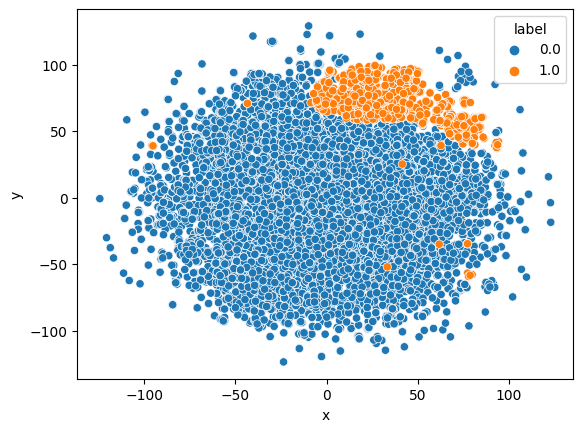

In [49]:
import seaborn as sns
sns.scatterplot(data=data_to_plot, x='x', y='y', hue='label')
plt.show()

### dists2

In [37]:
train_features = text_embeddings
train_labels = np.zeros(text_embeddings.shape[0])
eval_features = text_embeddings

centroid = text_embeddings.mean(dim=0)
sigma_inv = compute_inv_covariance(centroid.unsqueeze(0), text_embeddings, train_labels)[0]

dists1 = mahalanobis_distance_with_known_centroids_sigma_inv(centroid.unsqueeze(0), None,
                                                             sigma_inv, eval_features)
dists1

1it [00:08,  8.26s/it]


tensor([[30.7578],
        [34.2677],
        [30.8768],
        ...,
        [ 9.6536],
        [ 7.7658],
        [14.3075]])

In [16]:
dists1.shape

torch.Size([14436, 1])

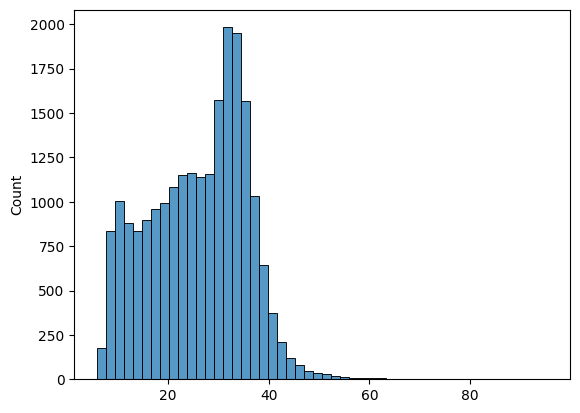

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(dists.squeeze(), bins=50)
plt.show()

### Examine far texts:

In [ ]:
df['MD'] = dists
# df['label'] = torch.cat([torch.zeros(14436), torch.ones(len(df) - 14436)])
df['label'] = torch.cat([torch.zeros(20000), torch.ones(len(df) - 20000)])

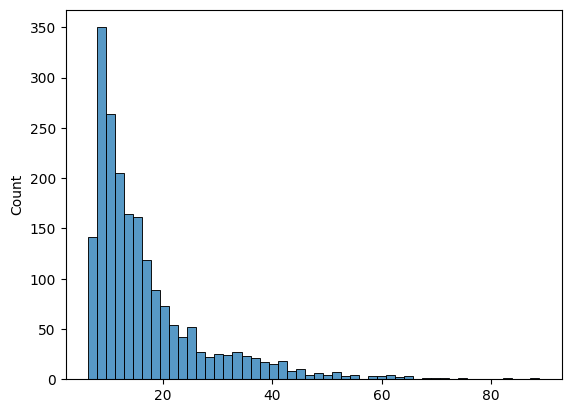

In [42]:
sns.histplot(dists[df['label'] == 1].squeeze(), bins=50)
plt.show()

In [43]:
a = torch.topk(torch.Tensor(dists.squeeze()), 1000).indices

In [44]:
torch.topk(torch.Tensor(dists.squeeze()), 150).values

tensor([95.4008, 88.7948, 82.6169, 74.2279, 74.0448, 72.4082, 72.0052, 70.8711,
        70.8594, 69.8702, 68.0168, 66.8990, 65.6492, 65.1980, 65.1064, 63.9795,
        63.6389, 62.7421, 62.5008, 62.3510, 62.0924, 61.8320, 61.2349, 61.0983,
        60.6772, 60.6305, 59.9473, 59.7349, 59.6087, 59.2767, 58.9213, 58.3233,
        58.3022, 58.0639, 58.0590, 58.0537, 57.7920, 57.6147, 57.5927, 57.4923,
        57.3125, 56.7423, 56.4972, 56.2372, 56.1558, 55.8533, 55.7395, 55.7102,
        55.4333, 55.4043, 55.2879, 55.2446, 54.8599, 54.8329, 54.7804, 54.7497,
        54.6017, 54.0465, 53.8530, 53.8426, 53.8252, 53.7191, 53.6654, 53.6261,
        53.4019, 53.3556, 53.2754, 52.9634, 52.9027, 52.8493, 52.6903, 52.6867,
        52.6521, 52.6435, 52.4045, 52.3379, 52.3379, 52.2344, 52.2071, 52.1429,
        52.0393, 51.9463, 51.9030, 51.8872, 51.8672, 51.7311, 51.6095, 51.4036,
        51.3771, 51.2632, 51.1733, 51.1292, 51.1094, 51.0124, 50.9663, 50.9646,
        50.9631, 50.9570, 50.8685, 50.86

In [27]:
np.quantile(dists, 0.95)

39.494206619262684

In [28]:
round((1 - 0.95)  * len(df))

1100

In [51]:
df.iloc[a]

,text,summary,MD,label
5160,"Friday, 28 August\nAFC Liverpool v Radcliffe B...",Here is the updated draw in full for the preli...,95.400787,0.0
21128,----------------------------------------------...,Be a Host Family!,88.794762,1.0
21451,==============================================...,SAVE $15 on Bibi Magazine's New Year's Eve Par...,82.616882,1.0
16522,Keep up to date with all of the confirmed deal...,The January transfer window closes in England ...,74.227928,0.0
20121,"Hey, I was screwing around on MLB.com.\nThe 20...",RedSox/Toronto,74.044807,1.0
...,...,...,...,...
9796,Ar raglen BBC Cymru Week in Week Out nos Fawrt...,Mae Iechyd Cyhoeddus Cymru wedi dweud bod llyg...,39.856453,0.0
5998,John Baird and Tom Taiwo were on target as pre...,Falkirk were impressive as they won away to Ra...,39.852421,0.0
15100,The Alpha Magnetic Spectrometer (AMS) was put ...,The scientist leading one of the most expensiv...,39.849903,0.0
12372,"Two studies, in the journal Cell, found a muta...",Ebola dramatically adapted to infect human tis...,39.849838,0.0


In [49]:
df.iloc[12231].text

'Dagenham bolstered their play-off prospects in the National League with an emphatic comeback win at 10-man Macclesfield.'

In [46]:
len(df.iloc[a])

1000

In [47]:
df.iloc[a]['label'].sum()

96.0

In [64]:
df.iloc[6247].summary

'Perspective'

In [65]:
df.iloc[6247].text

'It is said that some days are better than others,  but they should always be kept in perspective.\nYou have been, are and will  be the leader of Enron.\nYou are the man!\nBest Regards,\n'

## Remove far texts + update centroids & covariance matrix till convergence 

In [31]:
MAX_ITER = 15
EPS = 1e-4
# EPS = 0.015
quantile = 0.95

In [32]:
from datasets import DatasetDict, Dataset
from copy import deepcopy

1it [00:05,  5.83s/it]


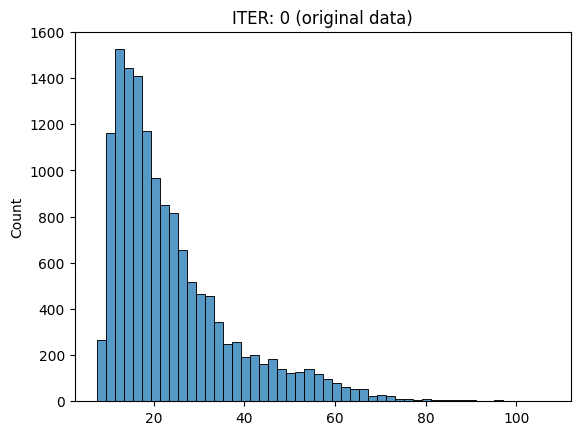

Saving the dataset (0/1 shards):   0%|          | 0/14436 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

ITER: 0
initial THRESHOLD: 55.83081130981446
retained objects num: 14436
ITER: 1
retained objects num before: 14436
retained objects num after: 13858


1it [00:05,  5.23s/it]


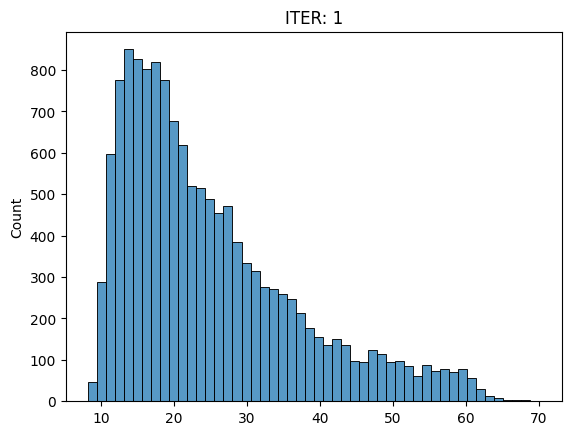

Saving the dataset (0/1 shards):   0%|          | 0/13858 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.19175836
ITER: 2
retained objects num before: 13858
retained objects num after: 13477


1it [00:05,  5.12s/it]


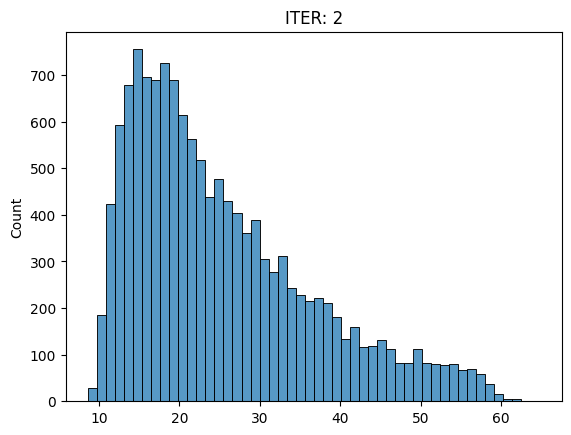

Saving the dataset (0/1 shards):   0%|          | 0/13477 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.10819024
ITER: 3
retained objects num before: 13477
retained objects num after: 13293


1it [00:05,  5.08s/it]


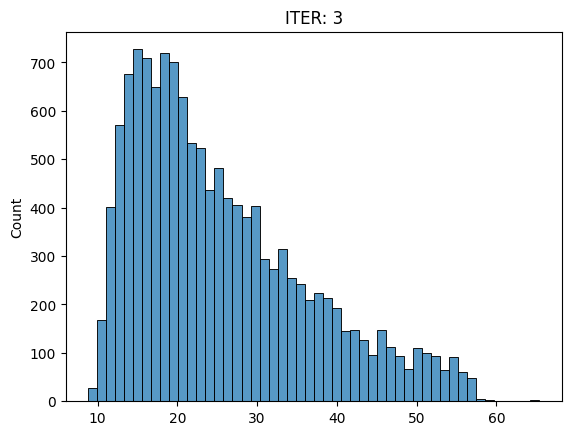

Saving the dataset (0/1 shards):   0%|          | 0/13293 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.04268791
ITER: 4
retained objects num before: 13293
retained objects num after: 13208


1it [00:05,  5.39s/it]


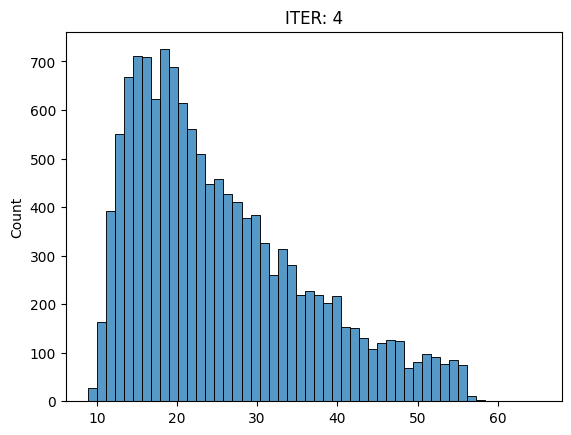

Saving the dataset (0/1 shards):   0%|          | 0/13208 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.019091185
ITER: 5
retained objects num before: 13208
retained objects num after: 13175


1it [00:05,  5.07s/it]


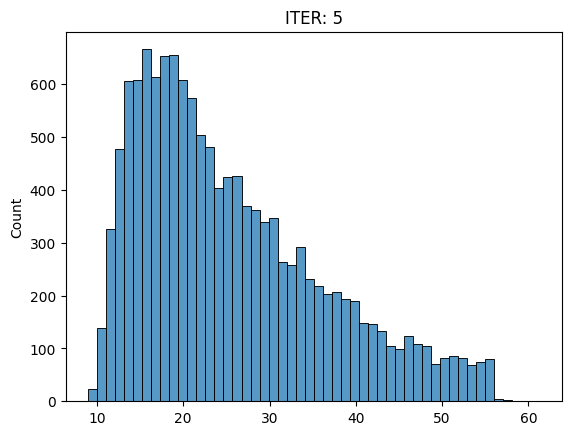

Saving the dataset (0/1 shards):   0%|          | 0/13175 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.0063062194
ITER: 6
retained objects num before: 13175
retained objects num after: 13158


1it [00:04,  4.95s/it]


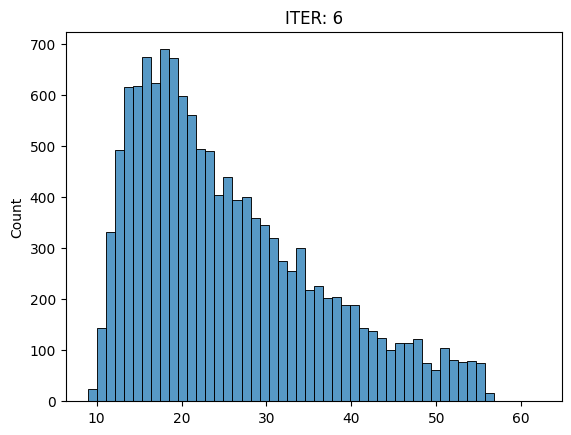

Saving the dataset (0/1 shards):   0%|          | 0/13158 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.0036078654
ITER: 7
retained objects num before: 13158
retained objects num after: 13149


1it [00:04,  4.93s/it]


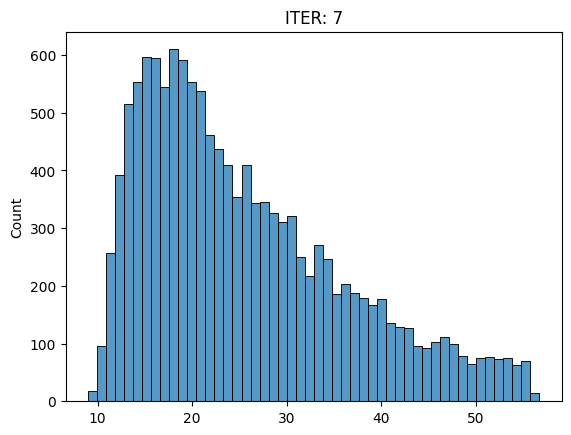

Saving the dataset (0/1 shards):   0%|          | 0/13149 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.0019065128
ITER: 8
retained objects num before: 13149
retained objects num after: 13145


1it [00:05,  5.29s/it]


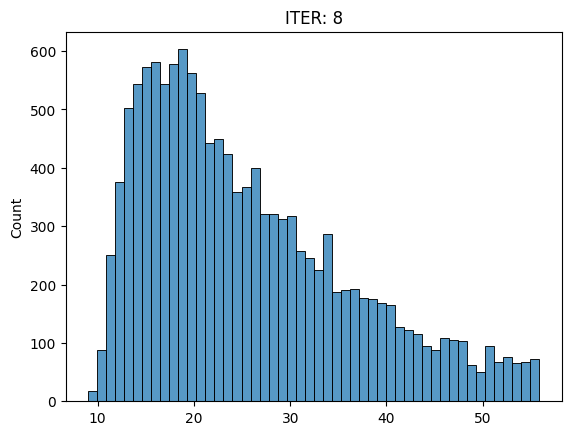

Saving the dataset (0/1 shards):   0%|          | 0/13145 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.00081572076
ITER: 9
retained objects num before: 13145
retained objects num after: 13141


1it [00:05,  5.02s/it]


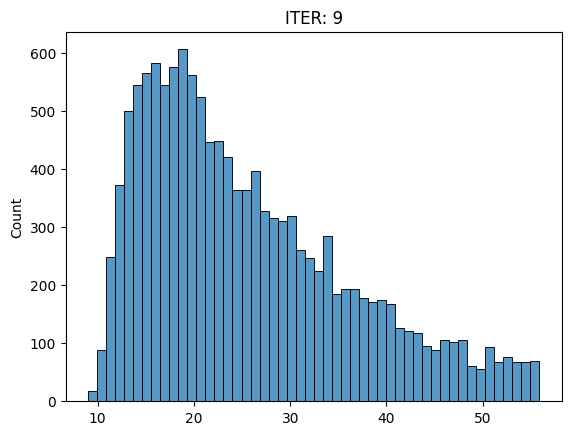

Saving the dataset (0/1 shards):   0%|          | 0/13141 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.0010924062
ITER: 10
retained objects num before: 13141
retained objects num after: 13138


1it [00:04,  4.92s/it]


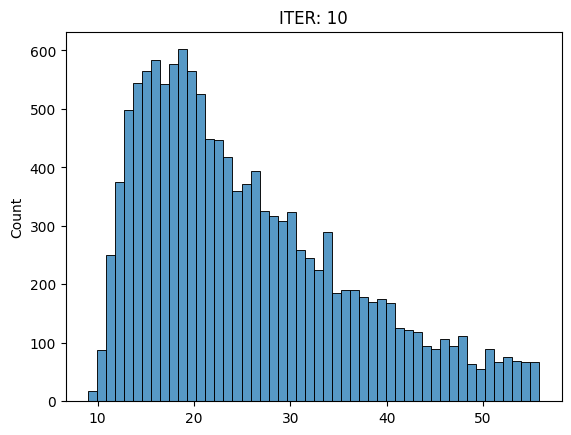

Saving the dataset (0/1 shards):   0%|          | 0/13138 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.00077375275
ITER: 11
retained objects num before: 13138
retained objects num after: 13137


1it [00:04,  4.92s/it]


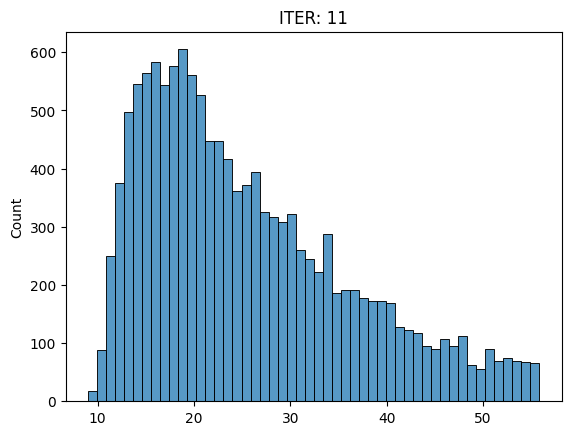

Saving the dataset (0/1 shards):   0%|          | 0/13137 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.00032568318
ITER: 12
retained objects num before: 13137
retained objects num after: 13136


1it [00:05,  5.22s/it]


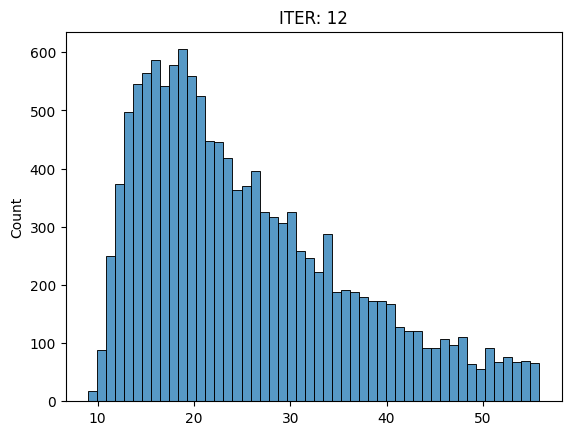

Saving the dataset (0/1 shards):   0%|          | 0/13136 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.00019186179
ITER: 13
retained objects num before: 13136
retained objects num after: 13135


1it [00:04,  4.91s/it]


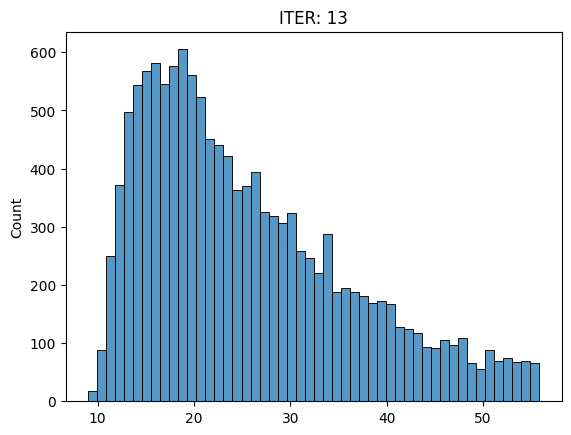

Saving the dataset (0/1 shards):   0%|          | 0/13135 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.0002354908
ITER: 14
retained objects num before: 13135
retained objects num after: 13134


1it [00:05,  5.15s/it]


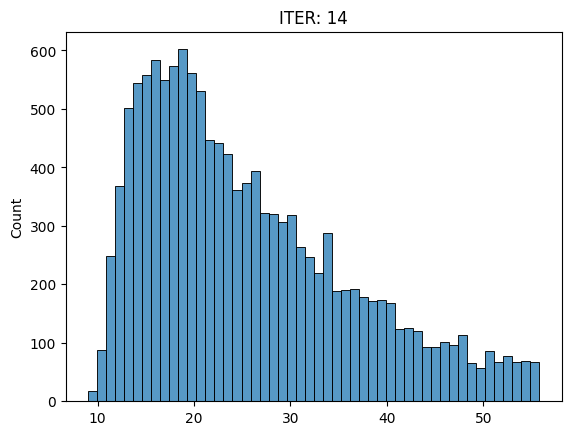

Saving the dataset (0/1 shards):   0%|          | 0/13134 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.0002818928


1it [00:05,  5.49s/it]


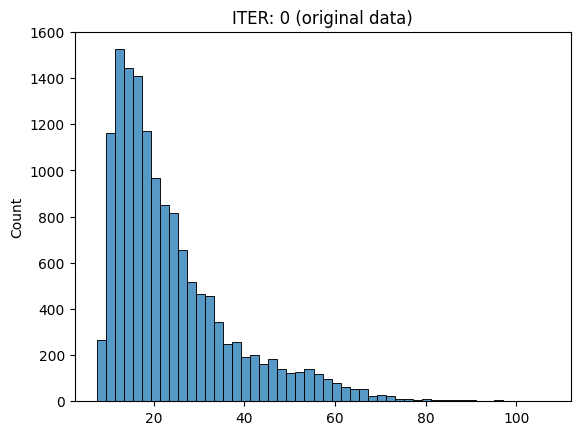

Saving the dataset (0/1 shards):   0%|          | 0/14436 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

ITER: 0
initial THRESHOLD: 58.534915351867625
retained objects num: 14436
ITER: 1
retained objects num before: 14436
retained objects num after: 14002


1it [00:05,  5.70s/it]


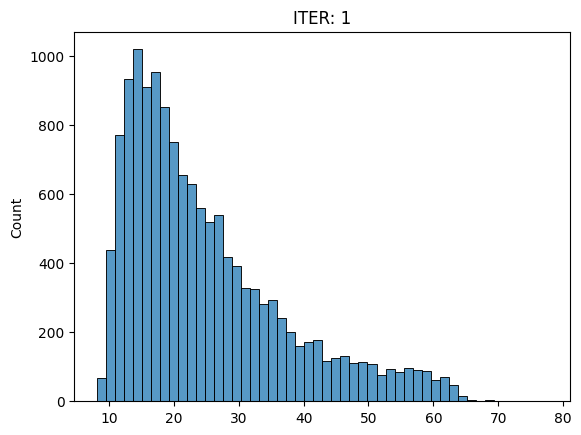

Saving the dataset (0/1 shards):   0%|          | 0/14002 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.14443983
ITER: 2
retained objects num before: 14002
retained objects num after: 13723


1it [00:05,  5.22s/it]


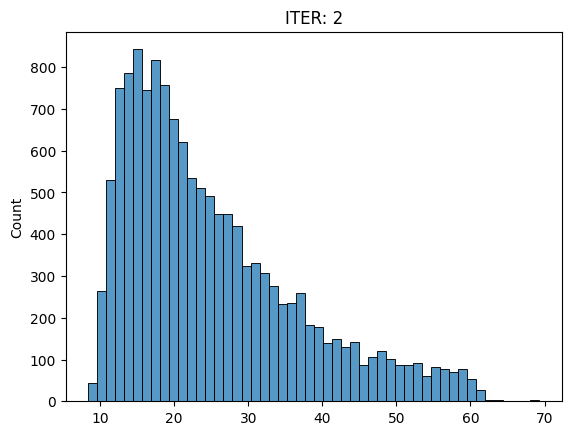

Saving the dataset (0/1 shards):   0%|          | 0/13723 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.08649073
ITER: 3
retained objects num before: 13723
retained objects num after: 13569


1it [00:05,  5.28s/it]


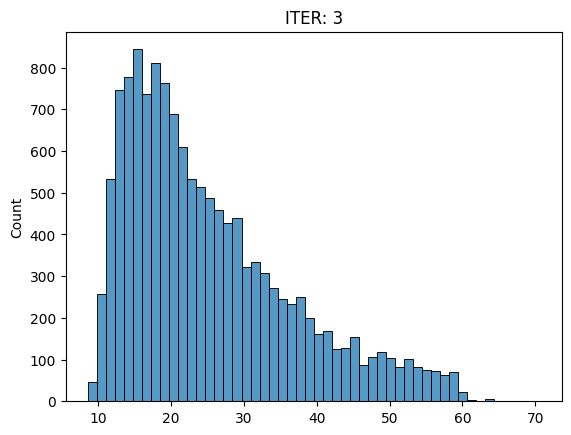

Saving the dataset (0/1 shards):   0%|          | 0/13569 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.044119902
ITER: 4
retained objects num before: 13569
retained objects num after: 13484


1it [00:05,  5.26s/it]


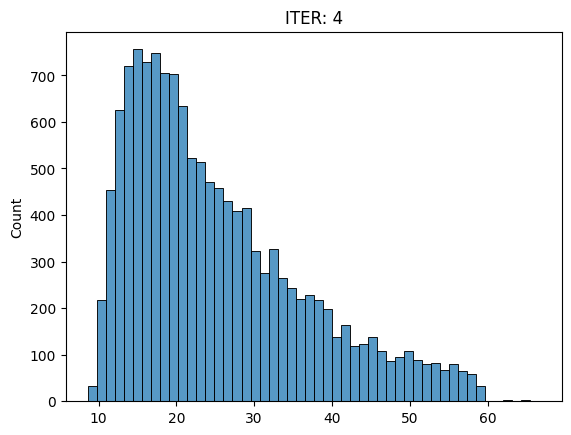

Saving the dataset (0/1 shards):   0%|          | 0/13484 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.02201438
ITER: 5
retained objects num before: 13484
retained objects num after: 13444


1it [00:05,  5.14s/it]


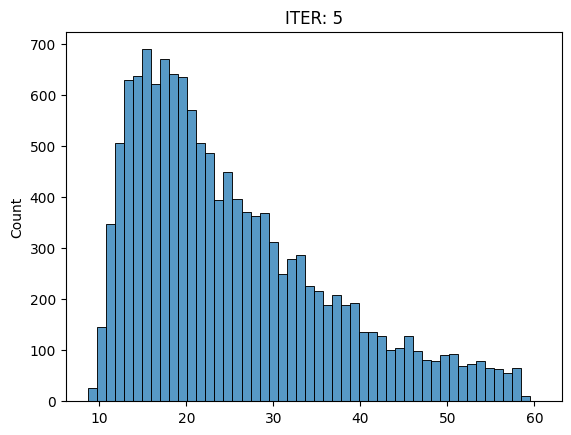

Saving the dataset (0/1 shards):   0%|          | 0/13444 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.010149625
ITER: 6
retained objects num before: 13444
retained objects num after: 13435


1it [00:05,  5.37s/it]


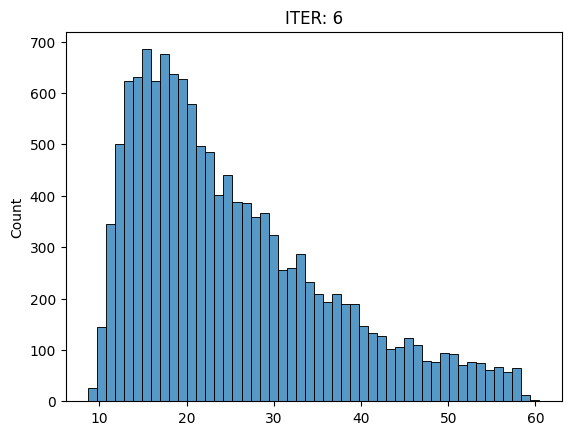

Saving the dataset (0/1 shards):   0%|          | 0/13435 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.002136482
ITER: 7
retained objects num before: 13435
retained objects num after: 13430


1it [00:05,  5.09s/it]


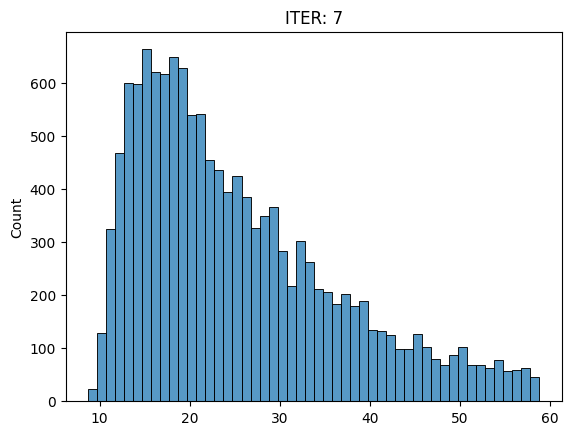

Saving the dataset (0/1 shards):   0%|          | 0/13430 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.0011254209
ITER: 8
retained objects num before: 13430
retained objects num after: 13427


1it [00:05,  5.17s/it]


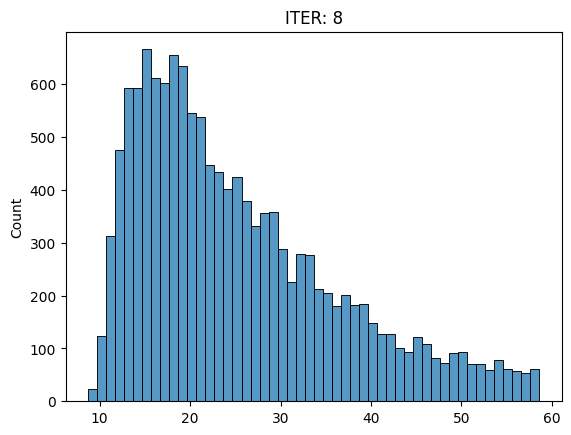

Saving the dataset (0/1 shards):   0%|          | 0/13427 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.0007145894
ITER: 9
retained objects num before: 13427
retained objects num after: 13426


1it [00:05,  5.01s/it]


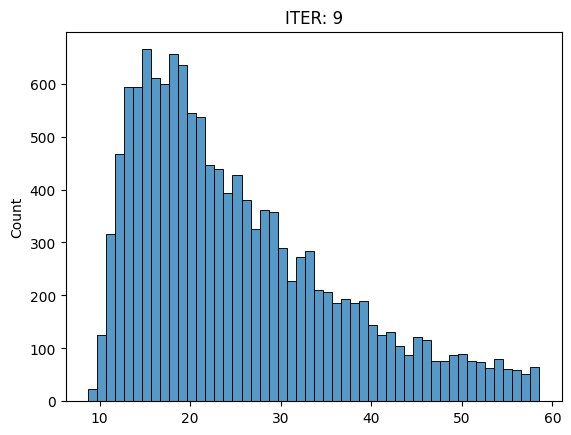

Saving the dataset (0/1 shards):   0%|          | 0/13426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.0002296909
ITER: 10
retained objects num before: 13426
retained objects num after: 13425


1it [00:05,  5.16s/it]


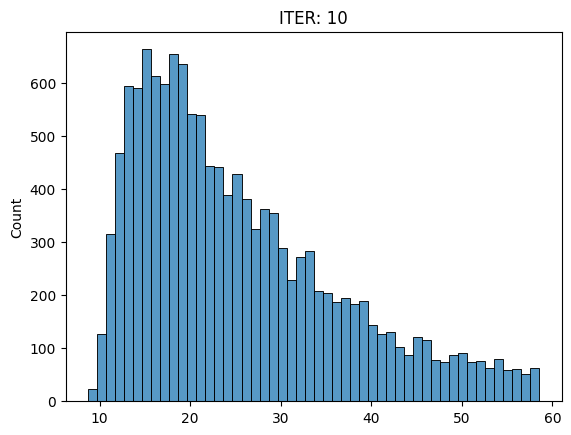

Saving the dataset (0/1 shards):   0%|          | 0/13425 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.00030746352
ITER: 11
retained objects num before: 13425
retained objects num after: 13425


1it [00:05,  5.08s/it]


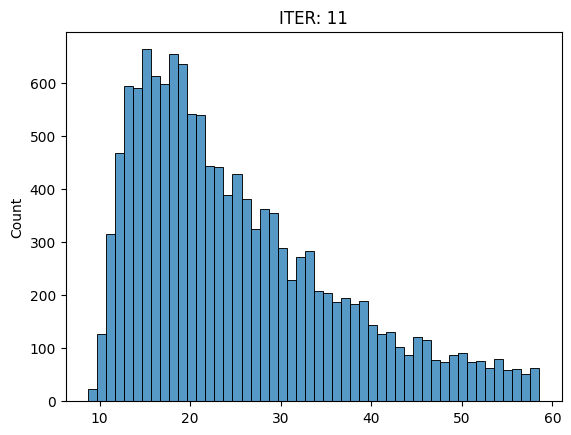

Saving the dataset (0/1 shards):   0%|          | 0/13425 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.0


1it [00:05,  5.58s/it]


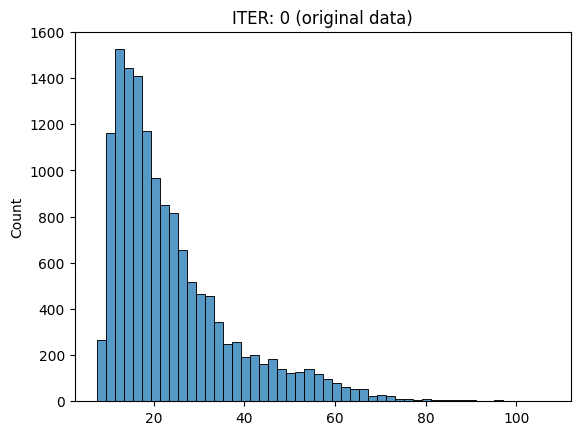

Saving the dataset (0/1 shards):   0%|          | 0/14436 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

ITER: 0
initial THRESHOLD: 62.194548034667896
retained objects num: 14436
ITER: 1
retained objects num before: 14436
retained objects num after: 14147


1it [00:05,  5.65s/it]


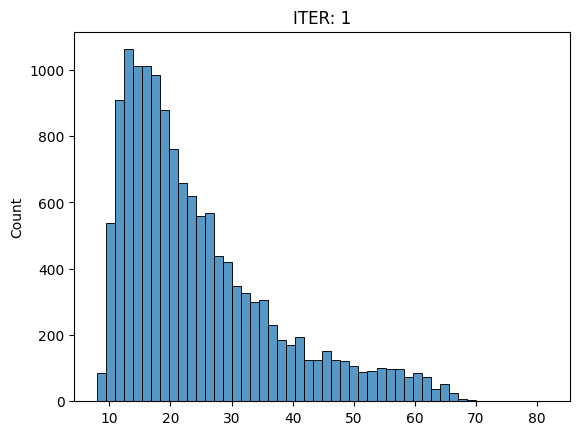

Saving the dataset (0/1 shards):   0%|          | 0/14147 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.09701973
ITER: 2
retained objects num before: 14147
retained objects num after: 14002


1it [00:05,  5.27s/it]


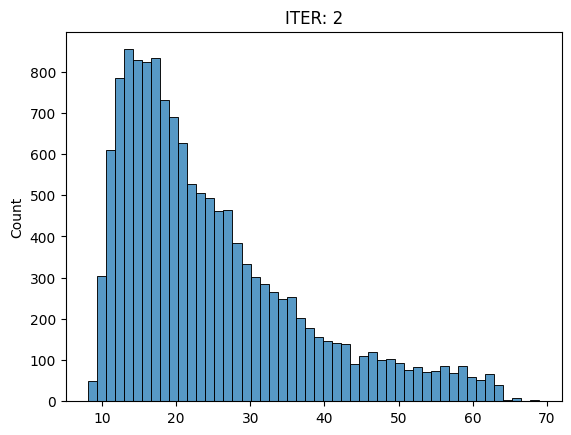

Saving the dataset (0/1 shards):   0%|          | 0/14002 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.045612503
ITER: 3
retained objects num before: 14002
retained objects num after: 13910


1it [00:05,  5.43s/it]


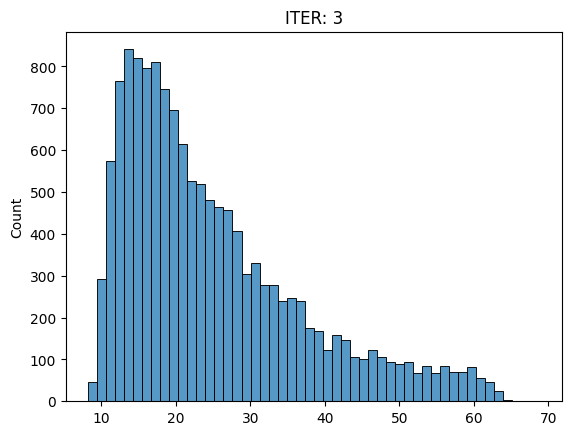

Saving the dataset (0/1 shards):   0%|          | 0/13910 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.029101482
ITER: 4
retained objects num before: 13910
retained objects num after: 13866


1it [00:05,  5.90s/it]


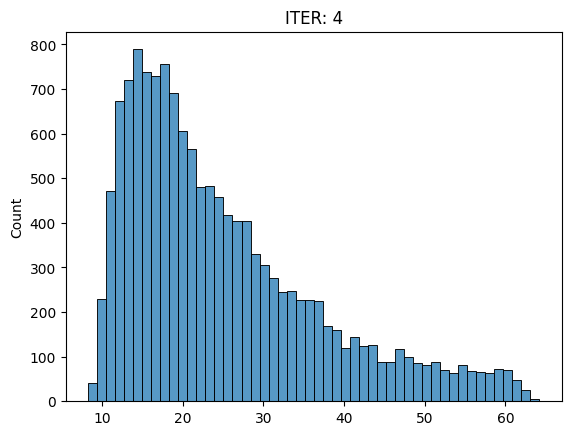

Saving the dataset (0/1 shards):   0%|          | 0/13866 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.01408235
ITER: 5
retained objects num before: 13866
retained objects num after: 13848


1it [00:05,  5.57s/it]


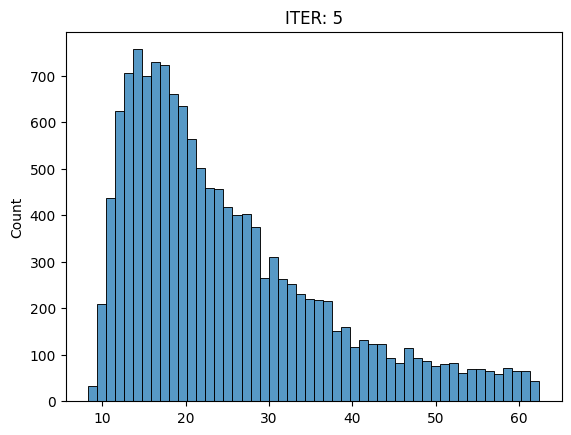

Saving the dataset (0/1 shards):   0%|          | 0/13848 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.005112874
ITER: 6
retained objects num before: 13848
retained objects num after: 13843


1it [00:05,  5.19s/it]


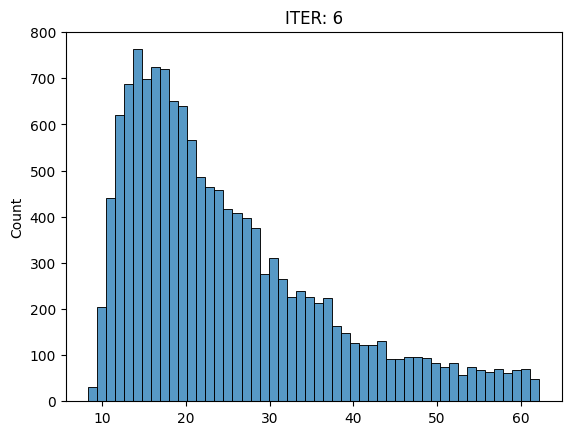

Saving the dataset (0/1 shards):   0%|          | 0/13843 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.0019816665
ITER: 7
retained objects num before: 13843
retained objects num after: 13840


1it [00:05,  5.28s/it]


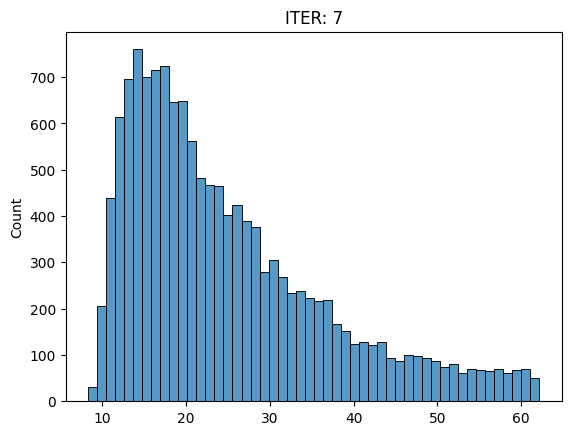

Saving the dataset (0/1 shards):   0%|          | 0/13840 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.0008254966
ITER: 8
retained objects num before: 13840
retained objects num after: 13840


1it [00:05,  5.31s/it]


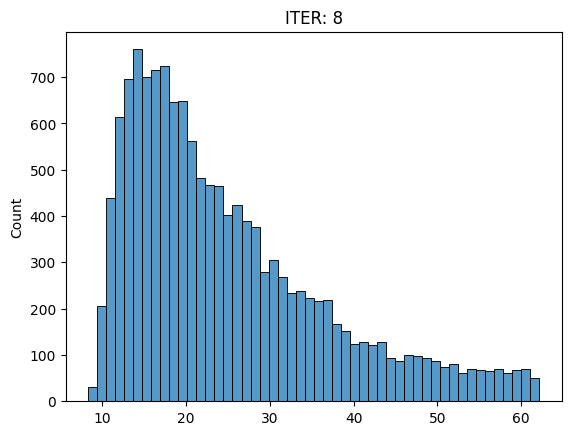

Saving the dataset (0/1 shards):   0%|          | 0/13840 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.0


1it [00:05,  5.44s/it]


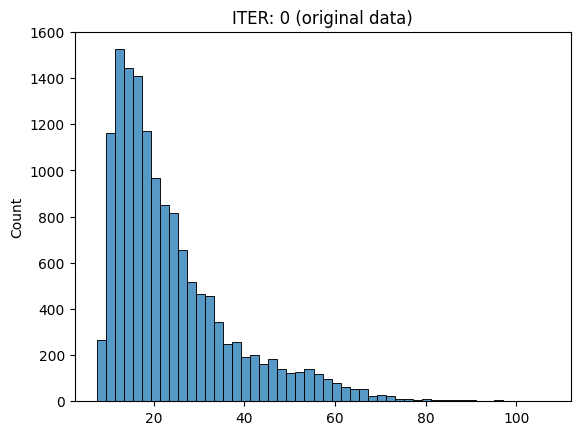

Saving the dataset (0/1 shards):   0%|          | 0/14436 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

ITER: 0
initial THRESHOLD: 67.77855644226071
retained objects num: 14436
ITER: 1
retained objects num before: 14436
retained objects num after: 14291


1it [00:05,  5.36s/it]


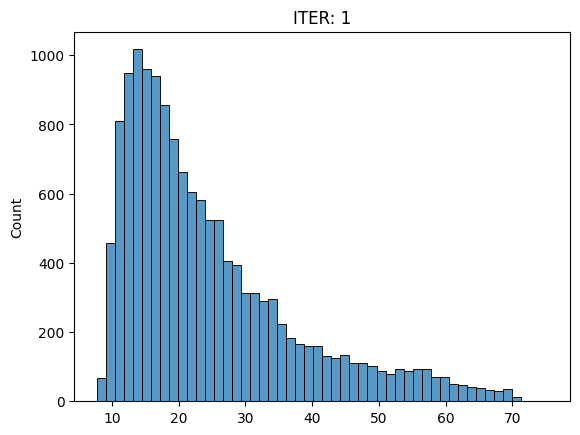

Saving the dataset (0/1 shards):   0%|          | 0/14291 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.048851367
ITER: 2
retained objects num before: 14291
retained objects num after: 14220


1it [00:05,  5.43s/it]


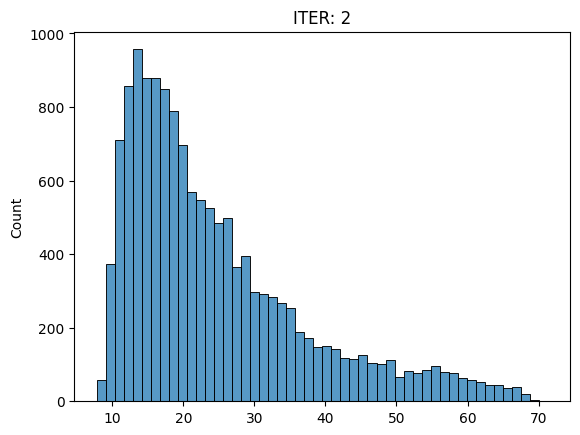

Saving the dataset (0/1 shards):   0%|          | 0/14220 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.02196638
ITER: 3
retained objects num before: 14220
retained objects num after: 14200


1it [00:05,  5.41s/it]


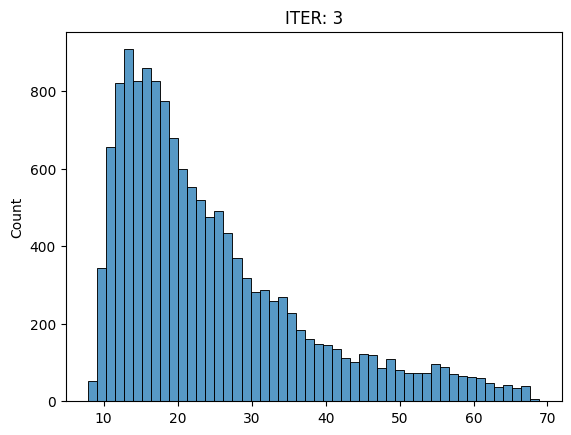

Saving the dataset (0/1 shards):   0%|          | 0/14200 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.007184851
ITER: 4
retained objects num before: 14200
retained objects num after: 14197


1it [00:05,  5.48s/it]


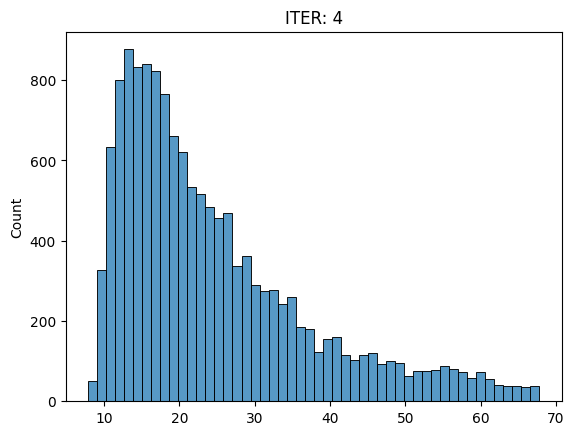

Saving the dataset (0/1 shards):   0%|          | 0/14197 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.0009766152
ITER: 5
retained objects num before: 14197
retained objects num after: 14197


1it [00:05,  5.57s/it]


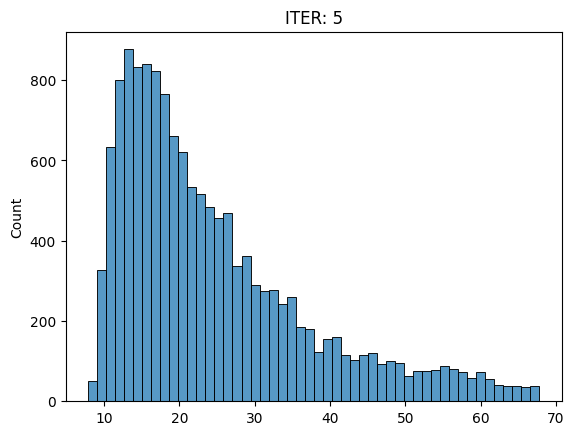

Saving the dataset (0/1 shards):   0%|          | 0/14197 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1960 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1906 [00:00<?, ? examples/s]

centroids distance: 0.0


In [33]:
for quantile in [0.95, 0.96, 0.97, 0.98, 0.99]:   
    train_features = text_embeddings
    train_labels = np.zeros(len(train_features))
    eval_features = text_embeddings

    centroids, centroids_mask = compute_centroids(train_features, train_labels)
    sigma_inv = compute_inv_covariance(centroids, train_features, train_labels)[0]
    dists = mahalanobis_distance_with_known_centroids_sigma_inv(centroids, centroids_mask, sigma_inv, eval_features).squeeze().numpy()

    sns.histplot(dists, bins=50).set(title='ITER: 0 (original data)')
    plt.show()

    retained_objects = np.ones(train_features.shape[0], dtype=np.bool)

    # save original dataset
    filtered_data = deepcopy(raw_data)
    filtered_data['train'] = Dataset.from_pandas(df[retained_objects])
    filtered_data.save_to_disk(f"filtered_data/ign_pad_{ignore_padding}/{dataset_name}_MD_{quantile}/iter_0.hf")

    THRESHOLD = np.quantile(dists, quantile)
    print("ITER:", 0)
    print('initial THRESHOLD:', THRESHOLD)
    print('retained objects num:', retained_objects.sum().item())

    for i in range(1, MAX_ITER):
        print('======================================')
        print("ITER:", i)
        print('retained objects num before:', retained_objects.sum().item())
        retained_objects[retained_objects == 1] = (retained_objects[retained_objects == 1] * \
                                                  (dists < THRESHOLD))
        print('retained objects num after:', retained_objects.sum().item())

        train_features = text_embeddings[retained_objects]
        train_labels = torch.zeros(len(train_features))
        eval_features = text_embeddings[retained_objects]
        new_centroids, new_centroids_mask = compute_centroids(train_features, train_labels)
        new_sigma_inv = compute_inv_covariance(new_centroids, train_features, train_labels)[0]
        dists = mahalanobis_distance_with_known_centroids_sigma_inv(new_centroids, new_centroids_mask, new_sigma_inv, eval_features).squeeze().numpy()
        # THRESHOLD = np.quantile(dists, quantile)
        # print('THRESHOLD:', THRESHOLD)
        sns.histplot(dists, bins=50).set(title='ITER: %i' % (i))
        plt.show()

        # save semi-filtered dataset
        filtered_data = deepcopy(raw_data)
        filtered_data['train'] = Dataset.from_pandas(df[retained_objects])
        filtered_data.save_to_disk(f"filtered_data/ign_pad_{ignore_padding}/{dataset_name}_MD_{quantile}/iter_{i}.hf")

        centroids_diff = np.linalg.norm(new_centroids - centroids)

        centroids = new_centroids
        centroids_mask = new_centroids_mask
        sigma_inv = new_sigma_inv

        print('centroids distance:', centroids_diff)
        print('======================================')

        if centroids_diff < EPS:
            break

In [22]:
# df.iloc[10187].text

In [30]:
filt_data = load_from_disk("/home/vakarlov/noise-in-abs-sum/filtered_data/ign_pad_False/aeslc_MD_0.95/iter_14.hf")
filt_data

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', '__index_level_0__'],
        num_rows: 12808
    })
    validation: Dataset({
        features: ['text', 'summary'],
        num_rows: 1960
    })
    test: Dataset({
        features: ['text', 'summary'],
        num_rows: 1906
    })
})

In [24]:
# df.drop_duplicates(['text'])

In [25]:
df[retained_objects].sort_values('MD', ascending=False)[:50]

KeyError: 'MD'

In [106]:
df[retained_objects]['labels'].sum()

455.0

In [107]:
len(df[retained_objects])

13971

In [105]:
# df.iloc[1142].text

In [87]:
filtered_data

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'MD', '__index_level_0__'],
        num_rows: 14669
    })
    validation: Dataset({
        features: ['text', 'summary'],
        num_rows: 1960
    })
    test: Dataset({
        features: ['text', 'summary'],
        num_rows: 1906
    })
})

In [ ]:
# from datasets import DatasetDict, Dataset
# from copy import deepcopy

# filtered_data = deepcopy(raw_data)
# filtered_data['train'] = Dataset.from_pandas(df[retained_objects])
# filtered_data

In [26]:
# # save filtered data to disk

# filtered_data.save_to_disk(dataset_name + "_filtered_data.hf")

In [35]:
# from datasets import DatasetDict, Dataset
# from copy import deepcopy

# filtered_data.save_to_disk(dataset_name + "_filtered_data.hf")
# filtered_data = deepcopy(raw_data)
# filtered_data['train'] = Dataset.from_pandas(df[retained_objects])
# filtered_data

# Loss Filtration

1. Загружаем из чекпоинта предобученную модель, которую файн-тюнили на суммаризацию на нешем датасете;
2. Считаем лосс на всех объектах (видимо, только в трейне);
3. Выкидывает high loss objects;
4. Переучиваем, измеряем качество.

In [5]:
if dataset_name == "aeslc":
    checkpoint_name = "sohamchougule/bart-large-finetuned-aeslc"
elif dataset_name in ("xsum", "xsum_sample"):
    checkpoint_name = "facebook/bart-large-xsum"
else:
    raise NotImplementedError('Unknown dataset')

In [6]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

tokenizer = AutoTokenizer.from_pretrained(checkpoint_name)
# tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
# tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-xsum")


In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint_name)

torch.cuda.empty_cache()
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model.to(device)
print()

In [7]:
def preprocess_function(examples):
    if 't5' in checkpoint_name.split('/')[-1].split('-'):
        prefix = "summarize: "
    else:
        prefix = ''
    
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True, padding='max_length', return_tensors='pt')
    labels = tokenizer(text_target=examples["summary"], max_length=128, truncation=True, padding='max_length', return_tensors='pt')
    model_inputs["labels"] = labels["input_ids"]
    # model_inputs = {key:value.to(device) for key, value in model_inputs.items()}  # положили на девайс
    return model_inputs

In [8]:
tokenized_data = raw_data['train'].map(preprocess_function, batched=True)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [18]:
from tqdm import tqdm

losses = []

for elem in tqdm(tokenized_data):
    loss = model(torch.Tensor(elem['input_ids']).to(torch.long).to(device).unsqueeze(0),
                 torch.Tensor(elem['attention_mask']).to(torch.long).to(device).unsqueeze(0),
                 labels=torch.Tensor(elem['labels']).to(torch.long).to(device).unsqueeze(0)).loss
    losses.append(loss.item())

100%|██████████| 14436/14436 [16:10<00:00, 14.87it/s]


In [19]:
# torch.save(losses, f"losses/{dataset_name}_losses.pt")

### Load losses

In [26]:
losses = torch.load(f"losses/{dataset_name}_losses.pt")

In [27]:
from copy import deepcopy

quantile = 0.99

losses = np.array(losses)
selected_inds = np.arange(tokenized_data.num_rows)[losses < np.quantile(losses, quantile)]
# tokenized_data = tokenized_data['train'][selected_inds]
filtered_data = deepcopy(raw_data)
filtered_data['train'] = Dataset.from_dict({'text' : tokenized_data[selected_inds]['text'],
                                            'summary' : tokenized_data[selected_inds]['summary']})

In [28]:
print(len(selected_inds))

19800


In [29]:
filtered_data

DatasetDict({
    train: Dataset({
        features: ['text', 'summary'],
        num_rows: 19800
    })
    validation: Dataset({
        features: ['text', 'summary', 'id', '__index_level_0__'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['text', 'summary', 'id', '__index_level_0__'],
        num_rows: 1500
    })
})

In [30]:
# save filtered dataset
filtered_data.save_to_disk(f"filtered_data/{dataset_name}_LOSS_{quantile}.hf")

Saving the dataset (0/1 shards):   0%|          | 0/19800 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1500 [00:00<?, ? examples/s]

#### Examine far texts

In [33]:
selected_inds = np.arange(tokenized_data.num_rows)[losses > np.quantile(losses, 0.99)]
tokenized_data[selected_inds]['text']

# Fine-tuning for summarization task

Предполагаемый пайплайн:
1. AESLC BERT (берт, unsupervised (на MLM task) дообученный на AESLC) --> эмбеддинги входных текстов (видимо, как усреденные пословные)
2. На полученных примерах считаем центроиды и ков. матрицу
3. Считаем расстояние Махаланобиса от центроидов 
4. Откидываем далекие примеры по трешхолду
5. Пересчитываем центроиды и ков. матрицу
6. Повторяем 2-6, пока центроиды меняются
7. Переучивыем модель для суммаризации на данных без выбросов и замеряем качество

In [6]:
# checkpoint_name = "facebook/bart-base"
checkpoint_name = "t5-small"

## Preprocess

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint_name)

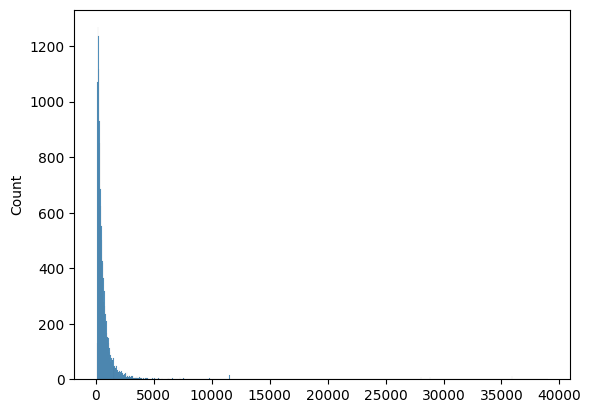

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

lens = list(map(len, raw_data['train']['text']))

sns.histplot(lens)
plt.show()

длины < 5000 --> max_length=1024 норм для токенайзера

In [9]:
# lens = list(map(len, raw_data['train']['summary']))

# sns.histplot(lens)
# plt.show()

In [10]:
def preprocess_function(examples):
    if checkpoint_name.split('/')[-1].split('-')[0] == 't5':
        prefix = "summarize: "
    else:
        prefix = ''
    
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True, padding='max_length')

    labels = tokenizer(text_target=examples["summary"], max_length=128, truncation=True, padding='max_length')

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [11]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [12]:
tokenized_orig_data = raw_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/14436 [00:00<?, ? examples/s]

Map:   0%|          | 0/1960 [00:00<?, ? examples/s]

Map:   0%|          | 0/1906 [00:00<?, ? examples/s]

## Metrics

In [13]:
# ! pip install rouge_score --quiet

In [14]:
import evaluate

rouge = evaluate.load("rouge", cache_dir=CACHE_DIR_PATH)

In [15]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

## Original data

In [18]:
! wandb disabled

W&B disabled.


In [19]:
# ! pip install wandb --quiet

In [20]:
import wandb

original_run_name = dataset_name + "_original_" + checkpoint_name

wandb.login()
wandb.init(project='noise-in-abs-sum',
           name=original_run_name)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [21]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

original_model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint_name)

In [22]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=original_model)

In [23]:
batch_size, eval_batch_size = 32, 64  # V100 config
# batch_size, eval_batch_size = 8, 16  # colab / local config

num_workers = 8

training_args = Seq2SeqTrainingArguments(
    output_dir=dataset_name + "-original-" + checkpoint_name,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=eval_batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True,
    report_to="wandb", 
    dataloader_num_workers=num_workers,
)

In [24]:
trainer = Seq2SeqTrainer(
    model=original_model,
    args=training_args,
    train_dataset=tokenized_orig_data["train"],
    eval_dataset=tokenized_orig_data["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [25]:
# train_model(original_model)
trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` m

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
wandb.finish()

## Filtered data

In [38]:
import wandb

filtered_run_name = "filtered " + checkpoint_name + '_' + str(quantile)

wandb.login()
wandb.init(project='noise-in-abs-sum',
           name=filtered_run_name)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vladimir_karlov. Use `wandb login --relogin` to force relogin


In [5]:
from datasets import load_from_disk

filtered_data = load_from_disk(dataset_name + "_filtered_data.hf")

wandb.log({'hyperparams/retained_obj_num' : filtered_data['train'].num_rows,
           # 'hyperparams/threshold' : THRESHOLD,
           'hyperparams/quantile' : quantile,
           'hyperparams/checkpoint_name' : checkpoint_name,
           'hyperparams/dataset_name' : dataset_name})

In [40]:
filtered_data

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', '__index_level_0__'],
        num_rows: 14064
    })
    validation: Dataset({
        features: ['text', 'summary'],
        num_rows: 1960
    })
    test: Dataset({
        features: ['text', 'summary'],
        num_rows: 1906
    })
})

In [ ]:
import evaluate

rouge = evaluate.load("rouge", cache_dir=CACHE_DIR_PATH)

In [41]:
tokenized_filtered_data = filtered_data.map(preprocess_function, batched=True)

  0%|          | 0/15 [00:00<?, ?ba/s]

Loading cached processed dataset at filtered_data.hf/validation/cache-c4df093ac437e651.arrow
Loading cached processed dataset at filtered_data.hf/test/cache-911be88f74bb6f90.arrow


In [42]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

filtered_model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint_name)

In [43]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=filtered_model)

In [54]:
batch_size, eval_batch_size = 32, 64  # V100 config
# batch_size, eval_batch_size = 8, 16  # colab / local config

num_workers = 6

training_args = Seq2SeqTrainingArguments(
    output_dir=dataset_name + "-filtered-" + checkpoint_name.split('/')[-1] + '_' + str(quantile),
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=eval_batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=True,
    report_to="wandb", 
    dataloader_num_workers=num_workers,
    
)

In [55]:
trainer = Seq2SeqTrainer(
    model=filtered_model,
    args=training_args,
    train_dataset=tokenized_filtered_data["train"],
    eval_dataset=tokenized_filtered_data["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Using cuda_amp half precision backend


In [ ]:
# train_model(filtered_model)
trainer.train()

The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: __index_level_0__, text, summary. If __index_level_0__, text, summary are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 14064
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1760
  Number of trainable parameters = 139420416
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BartTokenizerFast tokenizer. Please note that with a fa

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,No log,4.406018,0.337400,0.182700,0.328400,0.328200,7.746100
2,3.108800,4.366955,0.337600,0.180100,0.329800,0.329500,7.658400
3,2.634500,4.321293,0.338300,0.178600,0.330500,0.330600,7.594400


The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: summary, text. If summary, text are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1906
  Batch size = 64
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to 

In [ ]:
wandb.finish()